# About

 Nguyen Tran

This is a dog vs cat dataset, downloadable via kaggle or for microsoft see [Dogs and Cats](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  53.9M      0  0:00:14  0:00:14 --:--:-- 69.0M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [4]:
# removing corrupted image files
import os

folders = "Cat","Dog"
for folder in folders:
  p = os.path.join("PetImages", folder)
  for name in os.listdir(p):
    fp = os.path.join(p,name)
    try:
      y = open(fp, 'rb')
      x = tf.compat.as_bytes("JFIF") in y.peek(10)
    finally:
      y.close()
    if not x:
      os.remove(fp)

In [5]:
# splitting into train & validation
IMAGE_SIZE = 180,180
BATCH_SIZE = 32
EPOCHS = 2

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


## Sequential Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define the sequential model
model = Sequential([
    Flatten(input_shape=(180, 180, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [7]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
# Train the model
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/2
586/586 [==============================] - 185s 314ms/step - loss: 355.8236 - accuracy: 0.5174 - val_loss: 22.6185 - val_accuracy: 0.5201
Epoch 2/2
586/586 [==============================] - 166s 281ms/step - loss: 8.7974 - accuracy: 0.5430 - val_loss: 0.7793 - val_accuracy: 0.5416


In [9]:
# Evaluate the model on the validation data
_, test_acc = model.evaluate(val_ds, verbose=2)
print('Test accuracy:', test_acc)

147/147 - 9s - loss: 0.7793 - accuracy: 0.5416 - 9s/epoch - 64ms/step
Test accuracy: 0.5416488647460938


## CNN Model

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, LSTM
# Define the CNN model
model_cnn = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [14]:
# Compile the CNN model
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
# Train the CNN model
history_cnn = model_cnn.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=val_ds)

Epoch 1/2
586/586 [==============================] - 756s 1s/step - loss: 3.8763 - accuracy: 0.5705 - val_loss: 0.6842 - val_accuracy: 0.5519
Epoch 2/2
586/586 [==============================] - 789s 1s/step - loss: 0.6540 - accuracy: 0.6083 - val_loss: 0.6733 - val_accuracy: 0.5739


In [16]:
# Evaluate the CNN model on the test data
_, test_acc_cnn = model_cnn.evaluate(val_ds, verbose=2)
print('Test accuracy (CNN):', test_acc_cnn)

147/147 - 48s - loss: 0.6733 - accuracy: 0.5739 - 48s/epoch - 325ms/step
Test accuracy (CNN): 0.573900043964386


## Transfer Learning

In [28]:
from tensorflow.keras.applications.resnet50 import ResNet50
# Define the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [29]:
# Add new layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [30]:
# Combine the base model and new layers
model_transfer = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_transfer.compile(optimizer='adam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

In [31]:
# Train the model
history_transfer = model_transfer.fit(train_ds,
                                      epochs=EPOCHS,
                                      validation_data=val_ds)

Epoch 1/2


/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


586/586 [==============================] - 3149s 5s/step - loss: 0.0000e+00 - accuracy: 0.5034 - val_loss: 0.0000e+00 - val_accuracy: 0.4957
Epoch 2/2
586/586 [==============================] - 3077s 5s/step - loss: 0.0000e+00 - accuracy: 0.5030 - val_loss: 0.0000e+00 - val_accuracy: 0.4957


In [32]:
_, test_acc_transfer = model_transfer.evaluate(val_ds, verbose=2)
print('Test accuracy (transfer learning):', test_acc_transfer)

147/147 - 570s - loss: 0.0000e+00 - accuracy: 0.4957 - 570s/epoch - 4s/step
Test accuracy (transfer learning): 0.4957283139228821


## Compare

In [34]:
# Compare the test accuracies of all models
print('Test accuracy (Sequential):', test_acc)
print('Test accuracy (CNN):', test_acc_cnn)
print('Test accuracy (transfer learning):', test_acc_transfer)

Test accuracy (Sequential): 0.5416488647460938
Test accuracy (CNN): 0.573900043964386
Test accuracy (transfer learning): 0.4957283139228821


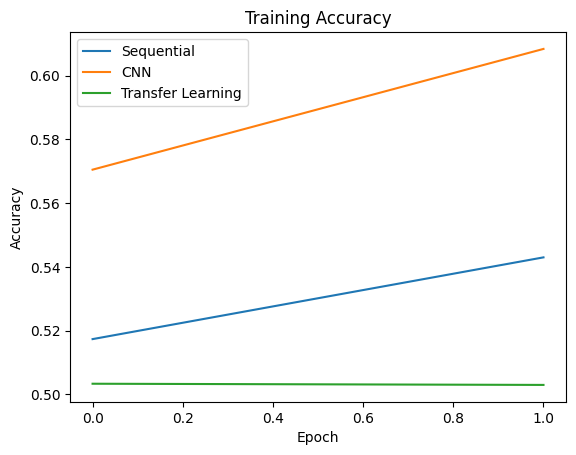

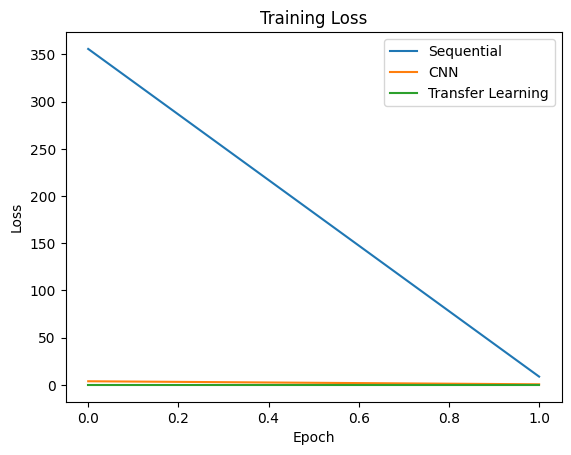

In [35]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy curves for all models
plt.plot(history.history['accuracy'], label='Sequential')
plt.plot(history_cnn.history['accuracy'], label='CNN')
plt.plot(history_transfer.history['accuracy'], label='Transfer Learning')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot the training and validation loss curves for all models
plt.plot(history.history['loss'], label='Sequential')
plt.plot(history_cnn.history['loss'], label='CNN')
plt.plot(history_transfer.history['loss'], label='Transfer Learning')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()